In [1]:

# data_setup.py
import torch.utils as utils
from torchvision import datasets, transforms

class DataSetup:
    def __init__(self, batch_size_train=64, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=2, pin_memory=None):
        self.batch_size_train = batch_size_train
        self.batch_size_test = batch_size_test
        self.shuffle_train = shuffle_train
        self.shuffle_test = shuffle_test
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.train_loader = self.get_train_loader()
        self.test_loader = self.get_test_loader()

    def get_train_transforms(self):
        train_transforms = transforms.Compose([
            transforms.RandomRotation((-7.0, 7.0), fill=(0,)),
            transforms.RandomAffine(0, translate=(0.08, 0.08)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
            ])
        return train_transforms

    def get_test_transforms(self):
        test_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
            ])
        return test_transforms

    def get_train_datasets(self):
        return datasets.MNIST('../data', train=True, download=True, transform=self.get_train_transforms())

    def get_test_datasets(self):
        return datasets.MNIST('../data', train=False, download=True, transform=self.get_test_transforms())

    def get_train_loader(self):
        train_dataset = self.get_train_datasets()
        return utils.data.DataLoader(train_dataset, batch_size=self.batch_size_train, shuffle=self.shuffle_train, num_workers=self.num_workers, pin_memory=self.pin_memory)

    def get_test_loader(self):
        test_dataset = self.get_test_datasets()
        return utils.data.DataLoader(test_dataset, batch_size=self.batch_size_test, shuffle=self.shuffle_test, num_workers=self.num_workers, pin_memory=self.pin_memory)


In [2]:
# summarizer.py
import torch.nn as nn
from torchsummary import summary

# -----------------------------
# 8. Model Architecture Checks
# -----------------------------
def model_checks(model):
    print('--- Model Architecture Checks ---')
    # Total Parameter Count
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total Parameter Count in Model: {total_params}\n')
    print('Layer-wise Parameter Details (in model order):')
    print('-'*80)
    # Get layers in order as defined in model
    for name, module in model.named_children():
        if isinstance(module, nn.Sequential):
            print(f"\nBlock: {name} (nn.Sequential)")
            for subname, submodule in module.named_children():
                layer_name = f'{name}.{subname} ({submodule.__class__.__name__})'
                layer_params = sum(p.numel() for p in submodule.parameters())
                details = ''
                if isinstance(submodule, nn.Conv2d):
                    details = f'Convolution: {submodule.in_channels} input channels, {submodule.out_channels} output channels, kernel size {submodule.kernel_size}, bias {submodule.bias is not None}'
                elif isinstance(submodule, nn.BatchNorm2d):
                    details = f'BatchNorm: {submodule.num_features} features, affine {submodule.affine}'
                elif isinstance(submodule, nn.ReLU):
                    details = 'Activation: ReLU (no parameters)'
                elif isinstance(submodule, nn.MaxPool2d):
                    details = f'MaxPooling: kernel size {submodule.kernel_size}, stride {submodule.stride}'
                elif isinstance(submodule, nn.Dropout):
                    details = f'Dropout: probability {submodule.p}'
                print(f'  {layer_name:40} | Params: {layer_params:6d} | {details}')
        else:
            layer_name = f'{name} ({module.__class__.__name__})'
            layer_params = sum(p.numel() for p in module.parameters())
            details = ''
            if isinstance(module, nn.AdaptiveAvgPool2d):
                details = f'Global Average Pooling: output size {module.output_size} (no parameters)'
            elif isinstance(module, nn.Linear):
                details = f'Fully Connected: {module.in_features} input features, {module.out_features} output features, bias {module.bias is not None}'
            print(f'  {layer_name:40} | Params: {layer_params:6d} | {details}')
    print('-'*80)
    print('\nSummary:')
    # BatchNorm
    bn_layers = [m for m in model.modules() if isinstance(m, nn.BatchNorm2d)]
    print(f'BatchNorm2d layers used: {len(bn_layers)}')
    # Dropout
    dropout_layers = [m for m in model.modules() if isinstance(m, nn.Dropout)]
    print(f'Dropout layers used: {len(dropout_layers)}')
    # Fully Connected & GAP
    fc_layers = [m for m in model.modules() if isinstance(m, nn.Linear)]
    gap_layers = [m for m in model.modules() if isinstance(m, nn.AdaptiveAvgPool2d)]
    print(f'Fully Connected (Linear) layers used: {len(fc_layers)}')
    print(f'Global Average Pooling layers used: {len(gap_layers)}')
    print('---------------------------------')



In [3]:
# train_test.py
from tqdm import tqdm
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


class train_test_model:

    def __init__(self, model, device, train_loader, test_loader):
        self.model = model
        self.device = device
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = self.set_criterion()
        self.optimizer = self.set_optimizer()
        self.scheduler = self.set_scheduler()
        self.train_acc_list = []
        self.test_acc_list = []
        self.F = F # Add F as a class attribute

    def set_criterion(self):
        return torch.nn.NLLLoss()

    def set_optimizer(self):
        return optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)

    def set_scheduler(self):
        return optim.lr_scheduler.StepLR(self.optimizer, step_size=4, gamma=0.1)

    def train(self, model, device, train_loader, optimizer, criterion):
        self.model.train()
        pbar = tqdm(self.train_loader)
        train_loss, correct, processed = 0, 0, 0
        for data, target in pbar:
            # get samples and move to device
            data, target = data.to(self.device), target.to(self.device)
            # Initialize optimizer
            self.optimizer.zero_grad()
            # Prediction
            output = self.model(data)
            # Calculate loss
            loss = self.F.nll_loss(output, target)
            # Backpropagation
            loss.backward()
            self.optimizer.step()
            # -----------------------------
            # Accumulate loss and calculate accuracy
            train_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)

            # Update progress bar with current statistics
            pbar.set_description(desc=f"Train Loss={train_loss / processed:.4f} Accuracy={100. * correct / processed:.2f}")

        return 100. * correct / len(self.train_loader.dataset)

    def test(self, model, device, test_loader, criterion):
        self.model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                test_loss += self.F.nll_loss(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(self.test_loader.dataset)
        acc = 100. * correct / len(self.test_loader.dataset)
        print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(self.test_loader.dataset)} ({acc:.2f}%)\n')
        return acc

    def do_training(self):
        return self.train(self.model, self.device, self.train_loader, self.optimizer, self.criterion)

    def do_testing(self):
        return self.test(self.model, self.device, self.test_loader, self.criterion)

    def run_epoch(self, epochs=1):
        for epoch in range(1, epochs+1):
            print(f"Epoch {epoch}")
            train_acc = self.do_training()
            test_acc = self.do_testing()
            self.scheduler.step()
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

    def plot_results(self):
        plt.plot(self.train_acc_list, label='Train Acc')
        plt.plot(self.test_acc_list, label='Test Acc')
        plt.legend()
        plt.title("Training vs Test Accuracy")
        plt.show()

In [4]:
from xml.parsers.expat import model
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# model_v0.py
#
# Model definition (parameter-efficient, <20k params)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=1, bias=False), # -> 4x28x28
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 8, 3, padding=1, bias=False), # -> 8x28x28
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # -> 8x14x14
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1, bias=False), # -> 16x14x14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1, bias=False), # -> 32x14x14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # -> 32x7x7
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 40, 3, padding=1, bias=False), # -> 40x7x7
            nn.BatchNorm2d(40),
            nn.ReLU(),
        )
        self.gap = nn.AdaptiveAvgPool2d(1) # -> 40x1x1
        self.fc = nn.Linear(40, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)



In [ ]:
# model_v1.py
from xml.parsers.expat import model
import torch
import torch.nn as nn
import torch.nn.functional as F

#
# Model definition (parameter-efficient, <20k params)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 2, 3, padding=1, bias=False), # -> 2x28x28
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1, bias=False), # -> 4x28x28
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 8, 3, padding=1, bias=False), # -> 8x28x28
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # -> 8x14x14
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 2, 3, padding=1, bias=False), # -> 2x14x14
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1, bias=False), # -> 4x14x14
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 8, 3, padding=1, bias=False), # -> 8x14x14
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # -> 8x7x7
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 2, 1, padding=1, bias=False), # -> 2x7x7
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1, bias=False), # -> 4x7x7
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 8, 3, padding=1, bias=False), # -> 8x7x7
            #nn.BatchNorm2d(8),
            #nn.ReLU(),
        )
        self.gap = nn.AdaptiveAvgPool2d(1) # -> 8x1x1
        self.fc = nn.Linear(8, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


In [ ]:
# model_v2.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_conv = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=1, bias=False), # -> 4x28x28
            nn.BatchNorm2d(4),
            nn.ReLU(),
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 8, 3, padding=1, bias=False), # -> 8x28x28
            nn.BatchNorm2d(8),
            nn.ReLU(),
            #nn.Dropout2d(0.05),
            nn.Conv2d(8, 16, 3, padding=1, bias=False), # -> 16x28x28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.MaxPool2d(2,2), # -> 8x14x14
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 8, 1, padding=1, bias=False), # -> 2x14x14
            nn.BatchNorm2d(8),
            nn.ReLU(),
            #nn.Dropout2d(0.05),
            nn.Conv2d(8, 16, 3, padding=1, bias=False), # -> 4x14x14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.MaxPool2d(2,2), # -> 8x7x7
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 8, 1, padding=1, bias=False), # -> 2x7x7
            nn.BatchNorm2d(8),
            nn.ReLU(),
            #nn.Dropout2d(0.05),
            nn.Conv2d(8, 16, 3, padding=1, bias=False), # -> 4x7x7
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.MaxPool2d(2,2), # -> 8x3x3
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 8, 1, padding=1, bias=False), # -> 2x7x7
            nn.BatchNorm2d(8),
            nn.ReLU(),
            #nn.Dropout2d(0.05),
            nn.Conv2d(8, 16, 3, padding=1, bias=False), # -> 4x7x7
        )
        self.gap = nn.AdaptiveAvgPool2d(1) # -> 8x1x1
        self.fc = nn.Linear(16, 10)

    def forward(self, x):
        x = self.input_conv(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [ ]:
# main.py
#import model_v0
#import summarizer
#import train_test
#import data_setup

class model_getter:
    def __init__(self,device=None):
        self.device = device if device else self.get_device()
        self.model_obj = self.get_model()

    def get_device(self):
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def get_model(self):
        return Net().to(self.device)

    def get_dataloader_args(self):
        if self.device.type == "cuda":
            return dict(batch_size_train=64, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0, pin_memory=False)
        else:
            return dict(batch_size_train=64, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0)

def get_model_obj():
    model_i = model_getter()
    summary(model_i.model_obj, input_size=(1, 28, 28))
    return model_i

def do_run(model):
    dataloader_args = model.get_dataloader_args()
    data_setup_instance = DataSetup(**dataloader_args)
    train_test_instance = train_test_model(model.model_obj, model.device, data_setup_instance.train_loader, data_setup_instance.test_loader)
    train_test_instance.run_epoch(epochs=15)
    train_test_instance.plot_results()

def main():
    # Initialize model, data loaders, and training/testing framework
    model = get_model_obj() #model_getter()
    #summary(model.model_obj, input_size=(1, 28, 28))
    do_run(model)
    #model_checks(model.model_obj)

main()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              36
       BatchNorm2d-2            [-1, 4, 28, 28]               8
              ReLU-3            [-1, 4, 28, 28]               0
            Conv2d-4            [-1, 8, 28, 28]             288
       BatchNorm2d-5            [-1, 8, 28, 28]              16
              ReLU-6            [-1, 8, 28, 28]               0
            Conv2d-7           [-1, 16, 28, 28]           1,152
       BatchNorm2d-8           [-1, 16, 28, 28]              32
              ReLU-9           [-1, 16, 28, 28]               0
        Dropout2d-10           [-1, 16, 28, 28]               0
        MaxPool2d-11           [-1, 16, 14, 14]               0
           Conv2d-12            [-1, 8, 16, 16]             128
      BatchNorm2d-13            [-1, 8, 16, 16]              16
             ReLU-14            [-1, 8,

Train Loss=0.0143 Accuracy=67.82: 100%|██████████| 938/938 [00:29<00:00, 31.44it/s]



Test set: Average loss: 0.0002, Accuracy: 9323/10000 (93.23%)

Epoch 2


Train Loss=0.0051 Accuracy=90.16: 100%|██████████| 938/938 [00:29<00:00, 31.68it/s]



Test set: Average loss: 0.0001, Accuracy: 9606/10000 (96.06%)

Epoch 3


Train Loss=0.0038 Accuracy=92.60: 100%|██████████| 938/938 [00:29<00:00, 31.36it/s]



Test set: Average loss: 0.0001, Accuracy: 9610/10000 (96.10%)

Epoch 4


Train Loss=0.0033 Accuracy=93.69: 100%|██████████| 938/938 [00:29<00:00, 31.90it/s]



Test set: Average loss: 0.0001, Accuracy: 9706/10000 (97.06%)

Epoch 5


Train Loss=0.0030 Accuracy=94.24: 100%|██████████| 938/938 [00:29<00:00, 32.24it/s]



Test set: Average loss: 0.0001, Accuracy: 9793/10000 (97.93%)

Epoch 6


Train Loss=0.0028 Accuracy=94.59: 100%|██████████| 938/938 [00:29<00:00, 31.61it/s]



Test set: Average loss: 0.0001, Accuracy: 9782/10000 (97.82%)

Epoch 7


Train Loss=0.0021 Accuracy=95.89: 100%|██████████| 938/938 [00:29<00:00, 32.17it/s]



Test set: Average loss: 0.0001, Accuracy: 9837/10000 (98.37%)

Epoch 8


Train Loss=0.0021 Accuracy=96.01: 100%|██████████| 938/938 [00:29<00:00, 31.95it/s]



Test set: Average loss: 0.0000, Accuracy: 9851/10000 (98.51%)

Epoch 9


Train Loss=0.0021 Accuracy=96.05: 100%|██████████| 938/938 [00:28<00:00, 32.36it/s]



Test set: Average loss: 0.0000, Accuracy: 9848/10000 (98.48%)

Epoch 10


Train Loss=0.0020 Accuracy=96.19: 100%|██████████| 938/938 [00:28<00:00, 32.45it/s]



Test set: Average loss: 0.0000, Accuracy: 9851/10000 (98.51%)

Epoch 11


Train Loss=0.0020 Accuracy=96.18: 100%|██████████| 938/938 [00:29<00:00, 31.95it/s]



Test set: Average loss: 0.0000, Accuracy: 9850/10000 (98.50%)

Epoch 12


Train Loss=0.0019 Accuracy=96.28: 100%|██████████| 938/938 [00:28<00:00, 32.37it/s]



Test set: Average loss: 0.0000, Accuracy: 9844/10000 (98.44%)

Epoch 13


Train Loss=0.0019 Accuracy=96.38:  69%|██████▉   | 650/938 [00:20<00:09, 31.56it/s]


KeyboardInterrupt: 

In [ ]:
# model_v2.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_conv = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=1, bias=False), # -> 4x28x28
            nn.BatchNorm2d(4),
            nn.ReLU(),
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 8, 3, padding=1, bias=False), # -> 8x28x28
            nn.BatchNorm2d(8),
            nn.ReLU(),
            #nn.Dropout2d(0.05),
            nn.Conv2d(8, 16, 3, padding=1, bias=False), # -> 16x28x28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.MaxPool2d(2,2), # -> 8x14x14
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 8, 1, padding=1, bias=False), # -> 2x14x14
            nn.BatchNorm2d(8),
            nn.ReLU(),
            #nn.Dropout2d(0.05),
            nn.Conv2d(8, 16, 3, padding=1, bias=False), # -> 4x14x14
        )
        self.gap = nn.AdaptiveAvgPool2d(1) # -> 8x1x1
        self.fc = nn.Linear(16, 10)

    def forward(self, x):
        x = self.input_conv(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [ ]:
class model_getter:
    def __init__(self,device=None):
        self.device = device if device else self.get_device()
        self.model_obj = self.get_model()

    def get_device(self):
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def get_model(self):
        return Net().to(self.device)

    def get_dataloader_args(self):
        if self.device.type == "cuda":
            return dict(batch_size_train=64, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0, pin_memory=False)
        else:
            return dict(batch_size_train=64, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0)

def get_model_obj():
    model_i = model_getter()
    summary(model_i.model_obj, input_size=(1, 28, 28))
    return model_i

def do_run(model):
    dataloader_args = model.get_dataloader_args()
    data_setup_instance = DataSetup(**dataloader_args)
    train_test_instance = train_test_model(model.model_obj, model.device, data_setup_instance.train_loader, data_setup_instance.test_loader)
    train_test_instance.run_epoch(epochs=15)
    train_test_instance.plot_results()

def main():
    # Initialize model, data loaders, and training/testing framework
    model = get_model_obj() #model_getter()
    #summary(model.model_obj, input_size=(1, 28, 28))
    do_run(model)
    #model_checks(model.model_obj)

main()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              36
       BatchNorm2d-2            [-1, 4, 28, 28]               8
              ReLU-3            [-1, 4, 28, 28]               0
            Conv2d-4            [-1, 8, 28, 28]             288
       BatchNorm2d-5            [-1, 8, 28, 28]              16
              ReLU-6            [-1, 8, 28, 28]               0
            Conv2d-7           [-1, 16, 28, 28]           1,152
       BatchNorm2d-8           [-1, 16, 28, 28]              32
              ReLU-9           [-1, 16, 28, 28]               0
        Dropout2d-10           [-1, 16, 28, 28]               0
        MaxPool2d-11           [-1, 16, 14, 14]               0
           Conv2d-12            [-1, 8, 16, 16]             128
      BatchNorm2d-13            [-1, 8, 16, 16]              16
             ReLU-14            [-1, 8,

Train Loss=0.0199 Accuracy=52.06: 100%|██████████| 938/938 [00:29<00:00, 31.64it/s]



Test set: Average loss: 0.0006, Accuracy: 8287/10000 (82.87%)

Epoch 2


Train Loss=0.0096 Accuracy=80.17: 100%|██████████| 938/938 [00:28<00:00, 32.93it/s]



Test set: Average loss: 0.0003, Accuracy: 9050/10000 (90.50%)

Epoch 3


Train Loss=0.0079 Accuracy=83.90: 100%|██████████| 938/938 [00:29<00:00, 31.61it/s]



Test set: Average loss: 0.0003, Accuracy: 9103/10000 (91.03%)

Epoch 4


Train Loss=0.0070 Accuracy=85.91: 100%|██████████| 938/938 [00:28<00:00, 32.81it/s]



Test set: Average loss: 0.0003, Accuracy: 9203/10000 (92.03%)

Epoch 5


Train Loss=0.0067 Accuracy=86.84:  65%|██████▌   | 614/938 [00:18<00:09, 32.69it/s]


KeyboardInterrupt: 

In [ ]:
# model_v2.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_conv = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, bias=False), # -> 4x28x28
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1, bias=False), # -> 8x28x28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.Dropout2d(0.05),
            nn.Conv2d(16, 16, 3, padding=1, bias=False), # -> 16x28x28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.MaxPool2d(2,2), # -> 8x14x14
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 8, 1, padding=1, bias=False), # -> 2x14x14
            nn.BatchNorm2d(8),
            nn.ReLU(),
            #nn.Dropout2d(0.05),
            nn.Conv2d(8, 16, 3, padding=1, bias=False), # -> 4x14x14
        )
        self.gap = nn.AdaptiveAvgPool2d(1) # -> 8x1x1
        self.fc = nn.Linear(16, 10)

    def forward(self, x):
        x = self.input_conv(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [ ]:
class model_getter:
    def __init__(self,device=None):
        self.device = device if device else self.get_device()
        self.model_obj = self.get_model()

    def get_device(self):
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def get_model(self):
        return Net().to(self.device)

    def get_dataloader_args(self):
        if self.device.type == "cuda":
            return dict(batch_size_train=64, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0, pin_memory=False)
        else:
            return dict(batch_size_train=64, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0)

def get_model_obj():
    model_i = model_getter()
    summary(model_i.model_obj, input_size=(1, 28, 28))
    return model_i

def do_run(model):
    dataloader_args = model.get_dataloader_args()
    data_setup_instance = DataSetup(**dataloader_args)
    train_test_instance = train_test_model(model.model_obj, model.device, data_setup_instance.train_loader, data_setup_instance.test_loader)
    train_test_instance.run_epoch(epochs=15)
    train_test_instance.plot_results()

def main():
    # Initialize model, data loaders, and training/testing framework
    model = get_model_obj() #model_getter()
    #summary(model.model_obj, input_size=(1, 28, 28))
    do_run(model)
    #model_checks(model.model_obj)

main()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           1,152
       BatchNorm2d-5           [-1, 16, 28, 28]              32
              ReLU-6           [-1, 16, 28, 28]               0
            Conv2d-7           [-1, 16, 28, 28]           2,304
       BatchNorm2d-8           [-1, 16, 28, 28]              32
              ReLU-9           [-1, 16, 28, 28]               0
        Dropout2d-10           [-1, 16, 28, 28]               0
        MaxPool2d-11           [-1, 16, 14, 14]               0
           Conv2d-12            [-1, 8, 16, 16]             128
      BatchNorm2d-13            [-1, 8, 16, 16]              16
             ReLU-14            [-1, 8,

Train Loss=0.0152 Accuracy=65.00: 100%|██████████| 938/938 [00:28<00:00, 32.65it/s]



Test set: Average loss: 0.0005, Accuracy: 8303/10000 (83.03%)

Epoch 2


Train Loss=0.0079 Accuracy=83.53: 100%|██████████| 938/938 [00:28<00:00, 32.54it/s]



Test set: Average loss: 0.0003, Accuracy: 9011/10000 (90.11%)

Epoch 3


Train Loss=0.0067 Accuracy=86.51: 100%|██████████| 938/938 [00:28<00:00, 32.86it/s]



Test set: Average loss: 0.0003, Accuracy: 8969/10000 (89.69%)

Epoch 4


Train Loss=0.0062 Accuracy=87.50: 100%|██████████| 938/938 [00:29<00:00, 31.95it/s]



Test set: Average loss: 0.0003, Accuracy: 8828/10000 (88.28%)

Epoch 5


Train Loss=0.0059 Accuracy=88.05:  33%|███▎      | 308/938 [00:09<00:19, 32.42it/s]


KeyboardInterrupt: 

In [ ]:
# model_v2.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_conv = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, bias=False), # -> 4x28x28
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout2d(0.05),
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1, bias=False), # -> 8x28x28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.Conv2d(16, 32, 3, padding=1, bias=False), # -> 16x28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.MaxPool2d(2,2), # -> 8x14x14
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 16, 1, padding=1, bias=False), # -> 2x14x14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.Conv2d(16, 32, 3, padding=1, bias=False), # -> 4x14x14
        )
        self.gap = nn.AdaptiveAvgPool2d(1) # -> 8x1x1
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x = self.input_conv(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [ ]:
class model_getter:
    def __init__(self,device=None):
        self.device = device if device else self.get_device()
        self.model_obj = self.get_model()

    def get_device(self):
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def get_model(self):
        return Net().to(self.device)

    def get_dataloader_args(self):
        if self.device.type == "cuda":
            return dict(batch_size_train=64, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0, pin_memory=False)
        else:
            return dict(batch_size_train=64, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0)

def get_model_obj():
    model_i = model_getter()
    summary(model_i.model_obj, input_size=(1, 28, 28))
    return model_i

def do_run(model):
    dataloader_args = model.get_dataloader_args()
    data_setup_instance = DataSetup(**dataloader_args)
    train_test_instance = train_test_model(model.model_obj, model.device, data_setup_instance.train_loader, data_setup_instance.test_loader)
    train_test_instance.run_epoch(epochs=15)
    train_test_instance.plot_results()

def main():
    # Initialize model, data loaders, and training/testing framework
    model = get_model_obj() #model_getter()
    #summary(model.model_obj, input_size=(1, 28, 28))
    do_run(model)
    #model_checks(model.model_obj)

main()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,152
       BatchNorm2d-6           [-1, 16, 28, 28]              32
              ReLU-7           [-1, 16, 28, 28]               0
         Dropout2d-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 32, 28, 28]           4,608
      BatchNorm2d-10           [-1, 32, 28, 28]              64
             ReLU-11           [-1, 32, 28, 28]               0
        Dropout2d-12           [-1, 32, 28, 28]               0
        MaxPool2d-13           [-1, 32, 14, 14]               0
           Conv2d-14           [-1, 16,

Train Loss=0.0180 Accuracy=58.50: 100%|██████████| 938/938 [00:28<00:00, 32.51it/s]



Test set: Average loss: 0.0004, Accuracy: 8873/10000 (88.73%)

Epoch 2


Train Loss=0.0094 Accuracy=80.05: 100%|██████████| 938/938 [00:29<00:00, 32.01it/s]



Test set: Average loss: 0.0003, Accuracy: 9231/10000 (92.31%)

Epoch 3


Train Loss=0.0077 Accuracy=84.06: 100%|██████████| 938/938 [00:28<00:00, 32.45it/s]



Test set: Average loss: 0.0002, Accuracy: 9374/10000 (93.74%)

Epoch 4


Train Loss=0.0069 Accuracy=85.90: 100%|██████████| 938/938 [00:29<00:00, 31.92it/s]



Test set: Average loss: 0.0002, Accuracy: 9371/10000 (93.71%)

Epoch 5


Train Loss=0.0062 Accuracy=87.31: 100%|██████████| 938/938 [00:28<00:00, 32.39it/s]



Test set: Average loss: 0.0002, Accuracy: 9443/10000 (94.43%)

Epoch 6


Train Loss=0.0060 Accuracy=87.68: 100%|██████████| 938/938 [00:28<00:00, 32.35it/s]



Test set: Average loss: 0.0001, Accuracy: 9599/10000 (95.99%)

Epoch 7


Train Loss=0.0050 Accuracy=90.07: 100%|██████████| 938/938 [00:29<00:00, 32.18it/s]



Test set: Average loss: 0.0001, Accuracy: 9644/10000 (96.44%)

Epoch 8


Train Loss=0.0048 Accuracy=90.36: 100%|██████████| 938/938 [00:29<00:00, 32.34it/s]



Test set: Average loss: 0.0001, Accuracy: 9670/10000 (96.70%)

Epoch 9


Train Loss=0.0047 Accuracy=90.61: 100%|██████████| 938/938 [00:29<00:00, 31.49it/s]



Test set: Average loss: 0.0001, Accuracy: 9676/10000 (96.76%)

Epoch 10


Train Loss=0.0046 Accuracy=90.86: 100%|██████████| 938/938 [00:28<00:00, 32.61it/s]



Test set: Average loss: 0.0001, Accuracy: 9665/10000 (96.65%)

Epoch 11


Train Loss=0.0046 Accuracy=90.62: 100%|██████████| 938/938 [00:29<00:00, 32.18it/s]



Test set: Average loss: 0.0001, Accuracy: 9667/10000 (96.67%)

Epoch 12


Train Loss=0.0045 Accuracy=90.91: 100%|██████████| 938/938 [00:29<00:00, 31.81it/s]


KeyboardInterrupt: 

In [ ]:
# model_v2.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_conv = nn.Sequential(
            nn.Conv2d(1, 10, 3, padding=0, bias=False), # -> 28x28
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(0.05),
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(10, 10, 3, padding=0, bias=False), # -> 28x28
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.Conv2d(10, 20, 3, padding=0, bias=False), # -> 28x28
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.MaxPool2d(2,2), # -> 14x14
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(20, 10, 1, padding=0, bias=False), # -> 14x14
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.Conv2d(10, 10, 3, padding=0, bias=False), # -> 14x14
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.Conv2d(10, 20, 3, padding=0, bias=False), # -> 14x14
            nn.BatchNorm2d(20),
            nn.ReLU(),
            #nn.MaxPool2d(2,2), # -> 8x7x7
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(20, 10, 1, padding=0, bias=False), # -> 7x7
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.Conv2d(10, 10, 7, padding=0, bias=False), # -> 1x1
        )
        self.gap = nn.AdaptiveAvgPool2d(1) # -> 8x1x1
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x = self.input_conv(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        #x = self.gap(x)
        x = x.view(x.size(0), -1)
        #x = self.fc(x)
        return F.log_softmax(x, dim=-1)

In [ ]:
class model_getter:
    def __init__(self,device=None):
        self.device = device if device else self.get_device()
        self.model_obj = self.get_model()

    def get_device(self):
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def get_model(self):
        return Net().to(self.device)

    def get_dataloader_args(self):
        if self.device.type == "cuda":
            return dict(batch_size_train=64, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0, pin_memory=False)
        else:
            return dict(batch_size_train=64, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0)

def get_model_obj():
    model_i = model_getter()
    summary(model_i.model_obj, input_size=(1, 28, 28))
    return model_i

def do_run(model):
    dataloader_args = model.get_dataloader_args()
    data_setup_instance = DataSetup(**dataloader_args)
    train_test_instance = train_test_model(model.model_obj, model.device, data_setup_instance.train_loader, data_setup_instance.test_loader)
    train_test_instance.run_epoch(epochs=15)
    train_test_instance.plot_results()

def main():
    # Initialize model, data loaders, and training/testing framework
    model = get_model_obj() #model_getter()
    #summary(model.model_obj, input_size=(1, 28, 28))
    do_run(model)
    #model_checks(model.model_obj)

main()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
         Dropout2d-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 20, 22, 22]           1,800
      BatchNorm2d-10           [-1, 20, 22, 22]              40
             ReLU-11           [-1, 20, 22, 22]               0
        Dropout2d-12           [-1, 20, 22, 22]               0
        MaxPool2d-13           [-1, 20, 11, 11]               0
           Conv2d-14           [-1, 10,

Train Loss=0.0067 Accuracy=86.34: 100%|██████████| 938/938 [00:31<00:00, 30.10it/s]



Test set: Average loss: 0.0001, Accuracy: 9778/10000 (97.78%)

Epoch 2


Train Loss=0.0035 Accuracy=93.16: 100%|██████████| 938/938 [00:29<00:00, 31.89it/s]



Test set: Average loss: 0.0000, Accuracy: 9860/10000 (98.60%)

Epoch 3


Train Loss=0.0030 Accuracy=94.18: 100%|██████████| 938/938 [00:29<00:00, 31.44it/s]



Test set: Average loss: 0.0000, Accuracy: 9860/10000 (98.60%)

Epoch 4


Train Loss=0.0027 Accuracy=94.70: 100%|██████████| 938/938 [00:29<00:00, 32.20it/s]



Test set: Average loss: 0.0000, Accuracy: 9878/10000 (98.78%)

Epoch 5


Train Loss=0.0026 Accuracy=94.99: 100%|██████████| 938/938 [00:29<00:00, 32.10it/s]



Test set: Average loss: 0.0000, Accuracy: 9871/10000 (98.71%)

Epoch 6


Train Loss=0.0024 Accuracy=95.36: 100%|██████████| 938/938 [00:29<00:00, 31.59it/s]



Test set: Average loss: 0.0000, Accuracy: 9882/10000 (98.82%)

Epoch 7


Train Loss=0.0020 Accuracy=96.23: 100%|██████████| 938/938 [00:29<00:00, 31.95it/s]



Test set: Average loss: 0.0000, Accuracy: 9908/10000 (99.08%)

Epoch 8


Train Loss=0.0019 Accuracy=96.44: 100%|██████████| 938/938 [00:29<00:00, 31.61it/s]



Test set: Average loss: 0.0000, Accuracy: 9911/10000 (99.11%)

Epoch 9


Train Loss=0.0018 Accuracy=96.50:  56%|█████▌    | 524/938 [00:16<00:12, 32.06it/s]


KeyboardInterrupt: 

In [ ]:
class model_getter:
    def __init__(self,device=None):
        self.device = device if device else self.get_device()
        self.model_obj = self.get_model()

    def get_device(self):
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def get_model(self):
        return Net().to(self.device)

    def get_dataloader_args(self):
        if self.device.type == "cuda":
            return dict(batch_size_train=128, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0, pin_memory=False)
        else:
            return dict(batch_size_train=128, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0)

def get_model_obj():
    model_i = model_getter()
    summary(model_i.model_obj, input_size=(1, 28, 28))
    return model_i

def do_run(model):
    dataloader_args = model.get_dataloader_args()
    data_setup_instance = DataSetup(**dataloader_args)
    train_test_instance = train_test_model(model.model_obj, model.device, data_setup_instance.train_loader, data_setup_instance.test_loader)
    train_test_instance.run_epoch(epochs=15)
    train_test_instance.plot_results()

def main():
    # Initialize model, data loaders, and training/testing framework
    model = get_model_obj() #model_getter()
    #summary(model.model_obj, input_size=(1, 28, 28))
    do_run(model)
    #model_checks(model.model_obj)

main()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
         Dropout2d-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 20, 22, 22]           1,800
      BatchNorm2d-10           [-1, 20, 22, 22]              40
             ReLU-11           [-1, 20, 22, 22]               0
        Dropout2d-12           [-1, 20, 22, 22]               0
        MaxPool2d-13           [-1, 20, 11, 11]               0
           Conv2d-14           [-1, 10,

Train Loss=0.0153 Accuracy=32.81: 100%|██████████| 469/469 [00:26<00:00, 17.69it/s]



Test set: Average loss: 0.0012, Accuracy: 5954/10000 (59.54%)

Epoch 2


Train Loss=0.0133 Accuracy=40.49:  27%|██▋       | 126/469 [00:07<00:19, 17.53it/s]


KeyboardInterrupt: 

In [ ]:
# model_v2.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_conv = nn.Sequential(
            nn.Conv2d(1, 10, 3, padding=0, bias=False), # -> 28x28
            nn.BatchNorm2d(10),
            nn.ReLU(),
            #nn.Dropout2d(0.05),
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(10, 10, 3, padding=0, bias=False), # -> 28x28
            nn.BatchNorm2d(10),
            nn.ReLU(),
            #nn.Dropout2d(0.05),
            nn.Conv2d(10, 20, 3, padding=0, bias=False), # -> 28x28
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.MaxPool2d(2,2), # -> 14x14
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(20, 10, 1, padding=0, bias=False), # -> 14x14
            nn.BatchNorm2d(10),
            nn.ReLU(),
            #nn.Dropout2d(0.05),
            nn.Conv2d(10, 10, 3, padding=0, bias=False), # -> 14x14
            nn.BatchNorm2d(10),
            nn.ReLU(),
            #nn.Dropout2d(0.05),
            nn.Conv2d(10, 20, 3, padding=0, bias=False), # -> 14x14
            nn.BatchNorm2d(20),
            nn.ReLU(),
            #nn.MaxPool2d(2,2), # -> 8x7x7
            nn.Dropout2d(0.05),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(20, 10, 1, padding=0, bias=False), # -> 7x7
            nn.BatchNorm2d(10),
            nn.ReLU(),
            #nn.Dropout2d(0.05),
            nn.Conv2d(10, 10, 7, padding=0, bias=False), # -> 1x1
        )
        self.gap = nn.AdaptiveAvgPool2d(1) # -> 8x1x1
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x = self.input_conv(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        #x = self.gap(x)
        x = x.view(x.size(0), -1)
        #x = self.fc(x)
        return F.log_softmax(x, dim=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
        Dropout2d-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             200
      BatchNorm2d-13           [-1, 10, 11, 11]              20
             ReLU-14           [-1, 10,

Train Loss=0.0047 Accuracy=90.33: 100%|██████████| 938/938 [00:28<00:00, 32.77it/s]



Test set: Average loss: 0.0001, Accuracy: 9821/10000 (98.21%)

Epoch 2


Train Loss=0.0024 Accuracy=95.19: 100%|██████████| 938/938 [00:28<00:00, 32.99it/s]



Test set: Average loss: 0.0000, Accuracy: 9879/10000 (98.79%)

Epoch 3


Train Loss=0.0019 Accuracy=96.19: 100%|██████████| 938/938 [00:28<00:00, 32.55it/s]



Test set: Average loss: 0.0000, Accuracy: 9875/10000 (98.75%)

Epoch 4


Train Loss=0.0019 Accuracy=96.42: 100%|██████████| 938/938 [00:28<00:00, 32.86it/s]



Test set: Average loss: 0.0000, Accuracy: 9899/10000 (98.99%)

Epoch 5


Train Loss=0.0017 Accuracy=96.68: 100%|██████████| 938/938 [00:28<00:00, 33.01it/s]



Test set: Average loss: 0.0000, Accuracy: 9912/10000 (99.12%)

Epoch 6


Train Loss=0.0016 Accuracy=96.81: 100%|██████████| 938/938 [00:29<00:00, 32.16it/s]



Test set: Average loss: 0.0000, Accuracy: 9878/10000 (98.78%)

Epoch 7


Train Loss=0.0012 Accuracy=97.58: 100%|██████████| 938/938 [00:28<00:00, 32.94it/s]



Test set: Average loss: 0.0000, Accuracy: 9927/10000 (99.27%)

Epoch 8


Train Loss=0.0011 Accuracy=97.70: 100%|██████████| 938/938 [00:29<00:00, 32.34it/s]



Test set: Average loss: 0.0000, Accuracy: 9930/10000 (99.30%)

Epoch 9


Train Loss=0.0011 Accuracy=97.89: 100%|██████████| 938/938 [00:28<00:00, 32.59it/s]



Test set: Average loss: 0.0000, Accuracy: 9929/10000 (99.29%)

Epoch 10


Train Loss=0.0011 Accuracy=97.89: 100%|██████████| 938/938 [00:28<00:00, 32.42it/s]



Test set: Average loss: 0.0000, Accuracy: 9928/10000 (99.28%)

Epoch 11


Train Loss=0.0011 Accuracy=97.92: 100%|██████████| 938/938 [00:28<00:00, 33.34it/s]



Test set: Average loss: 0.0000, Accuracy: 9940/10000 (99.40%)

Epoch 12


Train Loss=0.0010 Accuracy=97.95: 100%|██████████| 938/938 [00:28<00:00, 32.98it/s]



Test set: Average loss: 0.0000, Accuracy: 9939/10000 (99.39%)

Epoch 13


Train Loss=0.0010 Accuracy=98.00: 100%|██████████| 938/938 [00:28<00:00, 33.48it/s]



Test set: Average loss: 0.0000, Accuracy: 9939/10000 (99.39%)

Epoch 14


Train Loss=0.0010 Accuracy=97.99: 100%|██████████| 938/938 [00:28<00:00, 32.98it/s]



Test set: Average loss: 0.0000, Accuracy: 9938/10000 (99.38%)

Epoch 15


Train Loss=0.0010 Accuracy=98.07: 100%|██████████| 938/938 [00:29<00:00, 31.69it/s]



Test set: Average loss: 0.0000, Accuracy: 9937/10000 (99.37%)



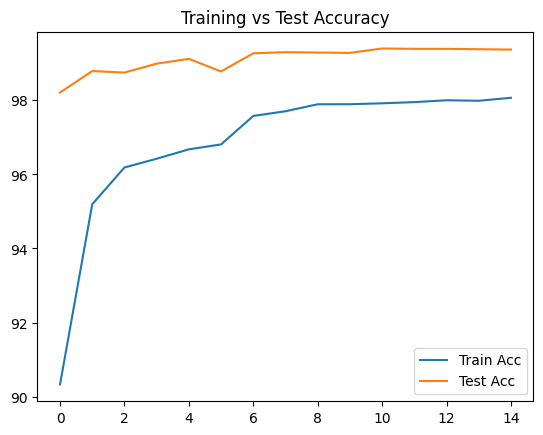

In [ ]:
class model_getter:
    def __init__(self,device=None):
        self.device = device if device else self.get_device()
        self.model_obj = self.get_model()

    def get_device(self):
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def get_model(self):
        return Net().to(self.device)

    def get_dataloader_args(self):
        if self.device.type == "cuda":
            return dict(batch_size_train=64, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0, pin_memory=False)
        else:
            return dict(batch_size_train=64, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0)

def get_model_obj():
    model_i = model_getter()
    summary(model_i.model_obj, input_size=(1, 28, 28))
    return model_i

def do_run(model):
    dataloader_args = model.get_dataloader_args()
    data_setup_instance = DataSetup(**dataloader_args)
    train_test_instance = train_test_model(model.model_obj, model.device, data_setup_instance.train_loader, data_setup_instance.test_loader)
    train_test_instance.run_epoch(epochs=15)
    train_test_instance.plot_results()

def main():
    # Initialize model, data loaders, and training/testing framework
    model = get_model_obj() #model_getter()
    #summary(model.model_obj, input_size=(1, 28, 28))
    do_run(model)
    #model_checks(model.model_obj)

main()

model_v2.py modifications

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Efficient Initial Feature Extraction (4 channels)
        self.input_conv = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=1, bias=False),  # -> 4x28x28
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Dropout2d(0.1),
        )

        # Light Encoder Block (8 channels)
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 8, 3, padding=1, bias=False),  # -> 8x28x28
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, padding=1, bias=False),  # -> 8x28x28
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # -> 8x14x14
        )

        # Efficient Feature Processing (16 channels)
        self.processor = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1, bias=False),  # -> 16x14x14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.Conv2d(16, 16, 3, padding=1, bias=False),  # -> 16x14x14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # -> 16x7x7
        )

        # Compact Global Context (10 channels)
        self.global_context = nn.Sequential(
            nn.Conv2d(16, 10, 1, bias=False),  # 1x1 conv directly to class count
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),  # Global Average Pooling -> 10x1x1
            nn.Flatten(),  # -> 10
        )

    def forward(self, x):
        x = self.input_conv(x)     # Initial feature extraction
        x = self.encoder(x)        # Encode and downsample
        x = self.processor(x)      # Process features
        x = self.global_context(x) # Global context and classification
        return F.log_softmax(x, dim=1)

In [ ]:
class model_getter:
    def __init__(self,device=None):
        self.device = device if device else self.get_device()
        self.model_obj = self.get_model()

    def get_device(self):
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def get_model(self):
        return Net().to(self.device)

    def get_dataloader_args(self):
        if self.device.type == "cuda":
            return dict(batch_size_train=64, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0, pin_memory=False)
        else:
            return dict(batch_size_train=64, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0)

def get_model_obj():
    model_i = model_getter()
    summary(model_i.model_obj, input_size=(1, 28, 28))
    return model_i

def do_run(model):
    dataloader_args = model.get_dataloader_args()
    data_setup_instance = DataSetup(**dataloader_args)
    train_test_instance = train_test_model(model.model_obj, model.device, data_setup_instance.train_loader, data_setup_instance.test_loader)
    train_test_instance.run_epoch(epochs=15)
    train_test_instance.plot_results()

def main():
    # Initialize model, data loaders, and training/testing framework
    model = get_model_obj() #model_getter()
    #summary(model.model_obj, input_size=(1, 28, 28))
    do_run(model)
    #model_checks(model.model_obj)

main()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              36
       BatchNorm2d-2            [-1, 4, 28, 28]               8
              ReLU-3            [-1, 4, 28, 28]               0
         Dropout2d-4            [-1, 4, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             288
       BatchNorm2d-6            [-1, 8, 28, 28]              16
              ReLU-7            [-1, 8, 28, 28]               0
            Conv2d-8            [-1, 8, 28, 28]             576
       BatchNorm2d-9            [-1, 8, 28, 28]              16
             ReLU-10            [-1, 8, 28, 28]               0
        MaxPool2d-11            [-1, 8, 14, 14]               0
           Conv2d-12           [-1, 16, 14, 14]           1,152
      BatchNorm2d-13           [-1, 16, 14, 14]              32
             ReLU-14           [-1, 16,

Train Loss=0.0121 Accuracy=79.58: 100%|██████████| 938/938 [00:28<00:00, 33.00it/s]



Test set: Average loss: 0.0002, Accuracy: 9609/10000 (96.09%)

Epoch 2


Train Loss=0.0041 Accuracy=93.55: 100%|██████████| 938/938 [00:28<00:00, 33.25it/s]



Test set: Average loss: 0.0001, Accuracy: 9723/10000 (97.23%)

Epoch 3


Train Loss=0.0032 Accuracy=94.68: 100%|██████████| 938/938 [00:28<00:00, 32.51it/s]



Test set: Average loss: 0.0001, Accuracy: 9752/10000 (97.52%)

Epoch 4


Train Loss=0.0028 Accuracy=95.21: 100%|██████████| 938/938 [00:28<00:00, 33.20it/s]



Test set: Average loss: 0.0001, Accuracy: 9776/10000 (97.76%)

Epoch 5


Train Loss=0.0025 Accuracy=95.81: 100%|██████████| 938/938 [00:28<00:00, 32.67it/s]



Test set: Average loss: 0.0001, Accuracy: 9819/10000 (98.19%)

Epoch 6


Train Loss=0.0023 Accuracy=95.93: 100%|██████████| 938/938 [00:29<00:00, 32.31it/s]



Test set: Average loss: 0.0001, Accuracy: 9821/10000 (98.21%)

Epoch 7


Train Loss=0.0019 Accuracy=96.69: 100%|██████████| 938/938 [00:29<00:00, 32.03it/s]



Test set: Average loss: 0.0000, Accuracy: 9882/10000 (98.82%)

Epoch 8


Train Loss=0.0019 Accuracy=96.77: 100%|██████████| 938/938 [00:30<00:00, 30.85it/s]



Test set: Average loss: 0.0000, Accuracy: 9868/10000 (98.68%)

Epoch 9


Train Loss=0.0018 Accuracy=96.89: 100%|██████████| 938/938 [00:30<00:00, 31.10it/s]



Test set: Average loss: 0.0000, Accuracy: 9860/10000 (98.60%)

Epoch 10


Train Loss=0.0018 Accuracy=96.94: 100%|██████████| 938/938 [00:30<00:00, 31.25it/s]



Test set: Average loss: 0.0000, Accuracy: 9865/10000 (98.65%)

Epoch 11


Train Loss=0.0017 Accuracy=97.03:  43%|████▎     | 401/938 [00:12<00:17, 31.52it/s]


KeyboardInterrupt: 

model_v2.py final block.

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Efficient Initial Feature Extraction (4 channels)
        self.input_conv = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=1, bias=False),  # -> 4x28x28
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 8, 3, padding=1, bias=False),  # -> 8x28x28
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # -> 8x14x14
        )

        # Focused Feature Learning (10 channels)
        self.feature_block = nn.Sequential(
            nn.Conv2d(8, 10, 3, padding=1, bias=False),  # -> 10x14x14
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.Conv2d(10, 12, 3, padding=1, bias=False),  # -> 12x14x14
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # -> 12x7x7
        )

        # Pattern Recognition with Skip Connection
        self.pattern_block = nn.Sequential(
            nn.Conv2d(12, 8, 1, bias=False),  # -> 8x7x7 (dimensionality reduction)
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 12, 3, padding=1, bias=False),  # -> 12x7x7
            nn.BatchNorm2d(12),
            nn.ReLU(),
            #nn.Dropout2d(0.05)
        )

        # Efficient Classification Head
        self.classifier = nn.Sequential(
            nn.Conv2d(12, 10, 1, bias=False),  # -> 10x7x7
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Conv2d(10, 10, 3, bias=False),  # -> 10x5x5
            nn.AvgPool2d(kernel_size=5),  # -> 10x1x1
            nn.Flatten()  # -> 10
        )

    def forward(self, x):
        # Initial feature extraction
        x = self.input_conv(x)

        # Feature learning
        x = self.feature_block(x)

        # Pattern recognition with residual-like behavior
        #identity = x
        x = self.pattern_block(x)
        #x = x + identity  # Skip connection for better gradient flow

        # Classification
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

In [15]:
class model_getter:
    def __init__(self,device=None):
        self.device = device if device else self.get_device()
        self.model_obj = self.get_model()

    def get_device(self):
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def get_model(self):
        return Net().to(self.device)

    def get_dataloader_args(self):
        if self.device.type == "cuda":
            return dict(batch_size_train=128, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0, pin_memory=False)
        else:
            return dict(batch_size_train=128, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0)

def get_model_obj():
    model_i = model_getter()
    summary(model_i.model_obj, input_size=(1, 28, 28))
    return model_i

def do_run(model):
    dataloader_args = model.get_dataloader_args()
    data_setup_instance = DataSetup(**dataloader_args)
    train_test_instance = train_test_model(model.model_obj, model.device, data_setup_instance.train_loader, data_setup_instance.test_loader)
    train_test_instance.run_epoch(epochs=15)
    train_test_instance.plot_results()

def main():
    # Initialize model, data loaders, and training/testing framework
    model = get_model_obj() #model_getter()
    #summary(model.model_obj, input_size=(1, 28, 28))
    #do_run(model)
    model_checks(model.model_obj)

main()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              36
       BatchNorm2d-2            [-1, 4, 28, 28]               8
              ReLU-3            [-1, 4, 28, 28]               0
            Conv2d-4            [-1, 8, 28, 28]             288
       BatchNorm2d-5            [-1, 8, 28, 28]              16
              ReLU-6            [-1, 8, 28, 28]               0
         MaxPool2d-7            [-1, 8, 14, 14]               0
            Conv2d-8           [-1, 10, 14, 14]             720
       BatchNorm2d-9           [-1, 10, 14, 14]              20
             ReLU-10           [-1, 10, 14, 14]               0
        Dropout2d-11           [-1, 10, 14, 14]               0
           Conv2d-12           [-1, 12, 14, 14]           1,080
      BatchNorm2d-13           [-1, 12, 14, 14]              24
             ReLU-14           [-1, 12,

model_v3.py to do is reduce the learning rate 0.01, final conv2d instead flatten(), stepLR step_size=4.


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Efficient Initial Feature Extraction (4 channels)
        self.input_conv = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=1, bias=False),  # -> 4x28x28
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 8, 3, padding=1, bias=False),  # -> 8x28x28
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # -> 8x14x14
        )

        # Focused Feature Learning (10 channels)
        self.feature_block = nn.Sequential(
            nn.Conv2d(8, 10, 3, padding=1, bias=False),  # -> 10x14x14
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.Conv2d(10, 12, 3, padding=1, bias=False),  # -> 12x14x14
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # -> 12x7x7
        )

        # Pattern Recognition
        self.pattern_block = nn.Sequential(
            nn.Conv2d(12, 8, 1, bias=False),  # -> 8x7x7 (dimensionality reduction)
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 12, 3, padding=1, bias=False),  # -> 12x7x7
            nn.BatchNorm2d(12),
            nn.ReLU(),
            #nn.Dropout2d(0.05)
        )

        # Efficient Classification Head
        self.classifier = nn.Sequential(
            nn.Conv2d(12, 10, 3, bias=False),  # -> 10x5x5
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Conv2d(10, 12, 3, bias=False),  # -> 12x3x3
            nn.AvgPool2d(kernel_size=3),  # -> 12x1x1
            nn.Conv2d(12, 10, 1, bias=False),  # -> 10x1x1
        )

    def forward(self, x):
        # Initial feature extraction
        x = self.input_conv(x)

        # Feature learning
        x = self.feature_block(x)

        # Pattern recognition with residual-like behavior
        x = self.pattern_block(x)

        # Classification
        x = self.classifier(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(x, dim=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              36
       BatchNorm2d-2            [-1, 4, 28, 28]               8
              ReLU-3            [-1, 4, 28, 28]               0
            Conv2d-4            [-1, 8, 28, 28]             288
       BatchNorm2d-5            [-1, 8, 28, 28]              16
              ReLU-6            [-1, 8, 28, 28]               0
         MaxPool2d-7            [-1, 8, 14, 14]               0
            Conv2d-8           [-1, 10, 14, 14]             720
       BatchNorm2d-9           [-1, 10, 14, 14]              20
             ReLU-10           [-1, 10, 14, 14]               0
        Dropout2d-11           [-1, 10, 14, 14]               0
           Conv2d-12           [-1, 12, 14, 14]           1,080
      BatchNorm2d-13           [-1, 12, 14, 14]              24
             ReLU-14           [-1, 12,

Train Loss=0.0042 Accuracy=83.58: 100%|██████████| 469/469 [00:40<00:00, 11.64it/s]



Test set: Average loss: 0.0995, Accuracy: 9692/10000 (96.92%)

Epoch 2


Train Loss=0.0009 Accuracy=96.52: 100%|██████████| 469/469 [00:38<00:00, 12.10it/s]



Test set: Average loss: 0.0671, Accuracy: 9792/10000 (97.92%)

Epoch 3


Train Loss=0.0007 Accuracy=97.30: 100%|██████████| 469/469 [00:38<00:00, 12.29it/s]



Test set: Average loss: 0.0835, Accuracy: 9728/10000 (97.28%)

Epoch 4


Train Loss=0.0006 Accuracy=97.59: 100%|██████████| 469/469 [00:39<00:00, 11.73it/s]



Test set: Average loss: 0.0488, Accuracy: 9844/10000 (98.44%)

Epoch 5


Train Loss=0.0005 Accuracy=98.22: 100%|██████████| 469/469 [00:41<00:00, 11.22it/s]



Test set: Average loss: 0.0333, Accuracy: 9892/10000 (98.92%)

Epoch 6


Train Loss=0.0004 Accuracy=98.17: 100%|██████████| 469/469 [00:41<00:00, 11.41it/s]



Test set: Average loss: 0.0331, Accuracy: 9897/10000 (98.97%)

Epoch 7


Train Loss=0.0004 Accuracy=98.28: 100%|██████████| 469/469 [00:40<00:00, 11.47it/s]



Test set: Average loss: 0.0328, Accuracy: 9891/10000 (98.91%)

Epoch 8


Train Loss=0.0004 Accuracy=98.37: 100%|██████████| 469/469 [00:41<00:00, 11.24it/s]



Test set: Average loss: 0.0321, Accuracy: 9895/10000 (98.95%)

Epoch 9


Train Loss=0.0004 Accuracy=98.40: 100%|██████████| 469/469 [00:41<00:00, 11.37it/s]



Test set: Average loss: 0.0318, Accuracy: 9896/10000 (98.96%)

Epoch 10


Train Loss=0.0004 Accuracy=98.37: 100%|██████████| 469/469 [00:41<00:00, 11.32it/s]



Test set: Average loss: 0.0321, Accuracy: 9897/10000 (98.97%)

Epoch 11


Train Loss=0.0004 Accuracy=98.41: 100%|██████████| 469/469 [00:40<00:00, 11.50it/s]



Test set: Average loss: 0.0315, Accuracy: 9899/10000 (98.99%)

Epoch 12


Train Loss=0.0004 Accuracy=98.38: 100%|██████████| 469/469 [00:42<00:00, 10.98it/s]



Test set: Average loss: 0.0316, Accuracy: 9894/10000 (98.94%)

Epoch 13


Train Loss=0.0004 Accuracy=98.38: 100%|██████████| 469/469 [00:41<00:00, 11.28it/s]



Test set: Average loss: 0.0313, Accuracy: 9896/10000 (98.96%)

Epoch 14


Train Loss=0.0004 Accuracy=98.44: 100%|██████████| 469/469 [00:42<00:00, 11.03it/s]



Test set: Average loss: 0.0310, Accuracy: 9894/10000 (98.94%)

Epoch 15


Train Loss=0.0004 Accuracy=98.42: 100%|██████████| 469/469 [00:42<00:00, 11.06it/s]



Test set: Average loss: 0.0315, Accuracy: 9896/10000 (98.96%)



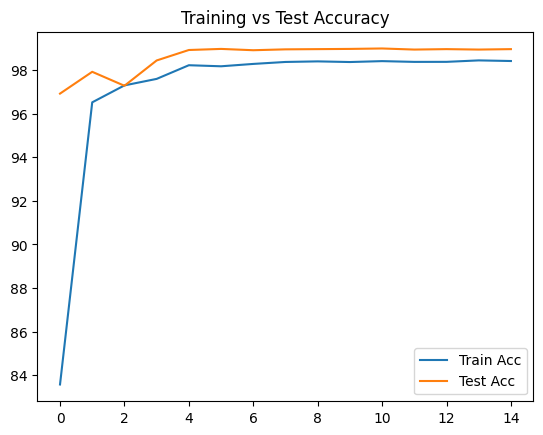

In [9]:
class model_getter:
    def __init__(self,device=None):
        self.device = device if device else self.get_device()
        self.model_obj = self.get_model()

    def get_device(self):
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def get_model(self):
        return Net().to(self.device)

    def get_dataloader_args(self):
        if self.device.type == "cuda":
            return dict(batch_size_train=128, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0, pin_memory=False)
        else:
            return dict(batch_size_train=128, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0)

def get_model_obj():
    model_i = model_getter()
    summary(model_i.model_obj, input_size=(1, 28, 28))
    return model_i

def do_run(model):
    dataloader_args = model.get_dataloader_args()
    data_setup_instance = DataSetup(**dataloader_args)
    train_test_instance = train_test_model(model.model_obj, model.device, data_setup_instance.train_loader, data_setup_instance.test_loader)
    train_test_instance.run_epoch(epochs=15)
    train_test_instance.plot_results()

def main():
    # Initialize model, data loaders, and training/testing framework
    model = get_model_obj() #model_getter()
    #summary(model.model_obj, input_size=(1, 28, 28))
    do_run(model)
    #model_checks(model.model_obj)

main()

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Efficient Initial Feature Extraction (4 channels)
        self.input_conv = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=1, bias=False),  # -> 4x28x28
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 8, 3, padding=1, bias=False),  # -> 8x28x28
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # -> 8x14x14
        )

        # Focused Feature Learning (10 channels)
        self.feature_block = nn.Sequential(
            nn.Conv2d(8, 10, 3, padding=1, bias=False),  # -> 10x14x14
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.Conv2d(10, 16, 3, padding=1, bias=False),  # -> 16x14x14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # -> 12x7x7
        )

        # Pattern Recognition
        self.pattern_block = nn.Sequential(
            nn.Conv2d(16, 8, 1, bias=False),  # -> 8x7x7 (dimensionality reduction)
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1, bias=False),  # -> 16x7x7
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.Dropout2d(0.05)
        )

        # Efficient Classification Head
        self.classifier = nn.Sequential(
            nn.Conv2d(16, 10, 3, bias=False),  # -> 10x5x5
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Conv2d(10, 16, 3, bias=False),  # -> 16x3x3
            nn.AvgPool2d(kernel_size=3),  # -> 16x1x1
            nn.Conv2d(16, 10, 1, bias=False),  # -> 16x1x1
        )

    def forward(self, x):
        # Initial feature extraction
        x = self.input_conv(x)

        # Feature learning
        x = self.feature_block(x)

        # Pattern recognition with residual-like behavior
        x = self.pattern_block(x)

        # Classification
        x = self.classifier(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(x, dim=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              36
       BatchNorm2d-2            [-1, 4, 28, 28]               8
              ReLU-3            [-1, 4, 28, 28]               0
            Conv2d-4            [-1, 8, 28, 28]             288
       BatchNorm2d-5            [-1, 8, 28, 28]              16
              ReLU-6            [-1, 8, 28, 28]               0
         MaxPool2d-7            [-1, 8, 14, 14]               0
            Conv2d-8           [-1, 10, 14, 14]             720
       BatchNorm2d-9           [-1, 10, 14, 14]              20
             ReLU-10           [-1, 10, 14, 14]               0
        Dropout2d-11           [-1, 10, 14, 14]               0
           Conv2d-12           [-1, 16, 14, 14]           1,440
      BatchNorm2d-13           [-1, 16, 14, 14]              32
             ReLU-14           [-1, 16,

Train Loss=0.0049 Accuracy=79.75: 100%|██████████| 469/469 [00:42<00:00, 10.95it/s]



Test set: Average loss: 0.0817, Accuracy: 9758/10000 (97.58%)

Epoch 2


Train Loss=0.0009 Accuracy=96.46: 100%|██████████| 469/469 [00:43<00:00, 10.71it/s]



Test set: Average loss: 0.0708, Accuracy: 9790/10000 (97.90%)

Epoch 3


Train Loss=0.0006 Accuracy=97.39: 100%|██████████| 469/469 [00:44<00:00, 10.58it/s]



Test set: Average loss: 0.0562, Accuracy: 9819/10000 (98.19%)

Epoch 4


Train Loss=0.0005 Accuracy=97.84: 100%|██████████| 469/469 [00:43<00:00, 10.86it/s]



Test set: Average loss: 0.0381, Accuracy: 9874/10000 (98.74%)

Epoch 5


Train Loss=0.0004 Accuracy=98.32: 100%|██████████| 469/469 [00:43<00:00, 10.85it/s]



Test set: Average loss: 0.0263, Accuracy: 9919/10000 (99.19%)

Epoch 6


Train Loss=0.0004 Accuracy=98.46: 100%|██████████| 469/469 [00:43<00:00, 10.68it/s]



Test set: Average loss: 0.0260, Accuracy: 9912/10000 (99.12%)

Epoch 7


Train Loss=0.0004 Accuracy=98.55: 100%|██████████| 469/469 [00:43<00:00, 10.75it/s]



Test set: Average loss: 0.0257, Accuracy: 9915/10000 (99.15%)

Epoch 8


Train Loss=0.0004 Accuracy=98.57: 100%|██████████| 469/469 [00:43<00:00, 10.83it/s]



Test set: Average loss: 0.0249, Accuracy: 9916/10000 (99.16%)

Epoch 9


Train Loss=0.0004 Accuracy=98.63: 100%|██████████| 469/469 [00:43<00:00, 10.91it/s]



Test set: Average loss: 0.0243, Accuracy: 9919/10000 (99.19%)

Epoch 10


Train Loss=0.0004 Accuracy=98.59: 100%|██████████| 469/469 [00:43<00:00, 10.77it/s]



Test set: Average loss: 0.0247, Accuracy: 9918/10000 (99.18%)

Epoch 11


Train Loss=0.0003 Accuracy=98.64: 100%|██████████| 469/469 [00:43<00:00, 10.83it/s]



Test set: Average loss: 0.0242, Accuracy: 9919/10000 (99.19%)

Epoch 12


Train Loss=0.0004 Accuracy=98.59: 100%|██████████| 469/469 [00:43<00:00, 10.86it/s]



Test set: Average loss: 0.0245, Accuracy: 9918/10000 (99.18%)

Epoch 13


Train Loss=0.0003 Accuracy=98.67: 100%|██████████| 469/469 [00:43<00:00, 10.70it/s]



Test set: Average loss: 0.0247, Accuracy: 9917/10000 (99.17%)

Epoch 14


Train Loss=0.0003 Accuracy=98.61: 100%|██████████| 469/469 [00:43<00:00, 10.86it/s]



Test set: Average loss: 0.0246, Accuracy: 9918/10000 (99.18%)

Epoch 15


Train Loss=0.0004 Accuracy=98.62: 100%|██████████| 469/469 [00:43<00:00, 10.89it/s]



Test set: Average loss: 0.0247, Accuracy: 9921/10000 (99.21%)



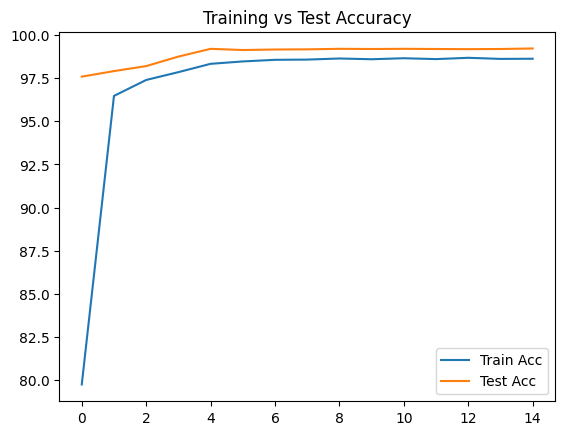

In [12]:
class model_getter:
    def __init__(self,device=None):
        self.device = device if device else self.get_device()
        self.model_obj = self.get_model()

    def get_device(self):
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def get_model(self):
        return Net().to(self.device)

    def get_dataloader_args(self):
        if self.device.type == "cuda":
            return dict(batch_size_train=128, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0, pin_memory=False)
        else:
            return dict(batch_size_train=128, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0)

def get_model_obj():
    model_i = model_getter()
    summary(model_i.model_obj, input_size=(1, 28, 28))
    return model_i

def do_run(model):
    dataloader_args = model.get_dataloader_args()
    data_setup_instance = DataSetup(**dataloader_args)
    train_test_instance = train_test_model(model.model_obj, model.device, data_setup_instance.train_loader, data_setup_instance.test_loader)
    train_test_instance.run_epoch(epochs=15)
    train_test_instance.plot_results()

def main():
    # Initialize model, data loaders, and training/testing framework
    model = get_model_obj() #model_getter()
    #summary(model.model_obj, input_size=(1, 28, 28))
    do_run(model)
    #model_checks(model.model_obj)

main()

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Efficient Initial Feature Extraction (4 channels)
        self.input_conv = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, bias=False),  # -> 8x28x28
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 10, 3, padding=1, bias=False),  # -> 10x28x28
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # -> 8x14x14
        )

        # Focused Feature Learning (10 channels)
        self.feature_block = nn.Sequential(
            nn.Conv2d(10, 10, 3, padding=1, bias=False),  # -> 10x14x14
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.Conv2d(10, 16, 3, padding=1, bias=False),  # -> 16x14x14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # -> 12x7x7
        )

        # Pattern Recognition
        self.pattern_block = nn.Sequential(
            nn.Conv2d(16, 10, 1, bias=False),  # -> 8x7x7 (dimensionality reduction)
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Conv2d(10, 16, 3, padding=1, bias=False),  # -> 16x7x7
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.Dropout2d(0.05)
        )

        # Efficient Classification Head
        self.classifier = nn.Sequential(
            nn.Conv2d(16, 10, 3, bias=False),  # -> 10x5x5
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Conv2d(10, 16, 3, bias=False),  # -> 16x3x3
            nn.AvgPool2d(kernel_size=3),  # -> 16x1x1
            nn.Conv2d(16, 10, 1, bias=False),  # -> 16x1x1
        )

    def forward(self, x):
        # Initial feature extraction
        x = self.input_conv(x)

        # Feature learning
        x = self.feature_block(x)

        # Pattern recognition with residual-like behavior
        x = self.pattern_block(x)

        # Classification
        x = self.classifier(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(x, dim=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
            Conv2d-4           [-1, 10, 28, 28]             720
       BatchNorm2d-5           [-1, 10, 28, 28]              20
              ReLU-6           [-1, 10, 28, 28]               0
         MaxPool2d-7           [-1, 10, 14, 14]               0
            Conv2d-8           [-1, 10, 14, 14]             900
       BatchNorm2d-9           [-1, 10, 14, 14]              20
             ReLU-10           [-1, 10, 14, 14]               0
        Dropout2d-11           [-1, 10, 14, 14]               0
           Conv2d-12           [-1, 16, 14, 14]           1,440
      BatchNorm2d-13           [-1, 16, 14, 14]              32
             ReLU-14           [-1, 16,

Train Loss=0.0041 Accuracy=83.88: 100%|██████████| 469/469 [00:50<00:00,  9.29it/s]



Test set: Average loss: 0.1117, Accuracy: 9640/10000 (96.40%)

Epoch 2


Train Loss=0.0008 Accuracy=97.14: 100%|██████████| 469/469 [00:49<00:00,  9.42it/s]



Test set: Average loss: 0.0818, Accuracy: 9736/10000 (97.36%)

Epoch 3


Train Loss=0.0006 Accuracy=97.84: 100%|██████████| 469/469 [00:49<00:00,  9.39it/s]



Test set: Average loss: 0.0521, Accuracy: 9821/10000 (98.21%)

Epoch 4


Train Loss=0.0005 Accuracy=98.07: 100%|██████████| 469/469 [00:49<00:00,  9.44it/s]



Test set: Average loss: 0.0328, Accuracy: 9895/10000 (98.95%)

Epoch 5


Train Loss=0.0004 Accuracy=98.52: 100%|██████████| 469/469 [00:49<00:00,  9.39it/s]



Test set: Average loss: 0.0246, Accuracy: 9920/10000 (99.20%)

Epoch 6


Train Loss=0.0004 Accuracy=98.62: 100%|██████████| 469/469 [00:49<00:00,  9.47it/s]



Test set: Average loss: 0.0233, Accuracy: 9925/10000 (99.25%)

Epoch 7


Train Loss=0.0003 Accuracy=98.64: 100%|██████████| 469/469 [00:49<00:00,  9.42it/s]



Test set: Average loss: 0.0226, Accuracy: 9928/10000 (99.28%)

Epoch 8


Train Loss=0.0003 Accuracy=98.71: 100%|██████████| 469/469 [00:49<00:00,  9.38it/s]



Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

Epoch 9


Train Loss=0.0003 Accuracy=98.77: 100%|██████████| 469/469 [00:50<00:00,  9.29it/s]



Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

Epoch 10


Train Loss=0.0003 Accuracy=98.73: 100%|██████████| 469/469 [00:50<00:00,  9.33it/s]



Test set: Average loss: 0.0217, Accuracy: 9930/10000 (99.30%)

Epoch 11


Train Loss=0.0003 Accuracy=98.72: 100%|██████████| 469/469 [00:49<00:00,  9.46it/s]



Test set: Average loss: 0.0215, Accuracy: 9930/10000 (99.30%)

Epoch 12


Train Loss=0.0003 Accuracy=98.72: 100%|██████████| 469/469 [00:50<00:00,  9.31it/s]



Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)

Epoch 13


Train Loss=0.0003 Accuracy=98.75: 100%|██████████| 469/469 [00:48<00:00,  9.60it/s]



Test set: Average loss: 0.0215, Accuracy: 9927/10000 (99.27%)

Epoch 14


Train Loss=0.0003 Accuracy=98.74: 100%|██████████| 469/469 [00:49<00:00,  9.51it/s]



Test set: Average loss: 0.0213, Accuracy: 9928/10000 (99.28%)

Epoch 15


Train Loss=0.0003 Accuracy=98.72: 100%|██████████| 469/469 [00:49<00:00,  9.43it/s]



Test set: Average loss: 0.0215, Accuracy: 9925/10000 (99.25%)



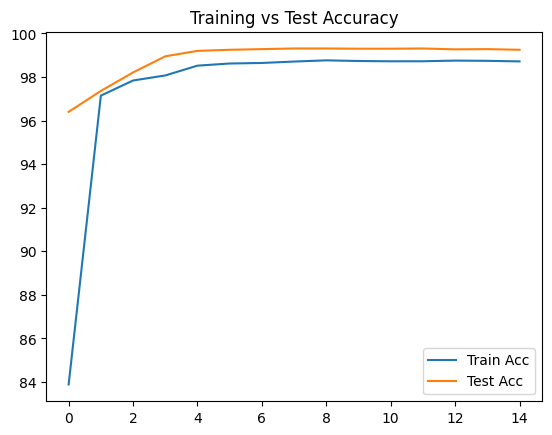

In [20]:
class model_getter:
    def __init__(self,device=None):
        self.device = device if device else self.get_device()
        self.model_obj = self.get_model()

    def get_device(self):
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def get_model(self):
        return Net().to(self.device)

    def get_dataloader_args(self):
        if self.device.type == "cuda":
            return dict(batch_size_train=128, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0, pin_memory=False)
        else:
            return dict(batch_size_train=128, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0)

def get_model_obj():
    model_i = model_getter()
    summary(model_i.model_obj, input_size=(1, 28, 28))
    return model_i

def do_run(model):
    dataloader_args = model.get_dataloader_args()
    data_setup_instance = DataSetup(**dataloader_args)
    train_test_instance = train_test_model(model.model_obj, model.device, data_setup_instance.train_loader, data_setup_instance.test_loader)
    train_test_instance.run_epoch(epochs=15)
    train_test_instance.plot_results()

def main():
    # Initialize model, data loaders, and training/testing framework
    model = get_model_obj() #model_getter()
    #summary(model.model_obj, input_size=(1, 28, 28))
    do_run(model)
    #model_checks(model.model_obj)

main()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
            Conv2d-4           [-1, 10, 28, 28]             720
       BatchNorm2d-5           [-1, 10, 28, 28]              20
              ReLU-6           [-1, 10, 28, 28]               0
         MaxPool2d-7           [-1, 10, 14, 14]               0
            Conv2d-8           [-1, 10, 14, 14]             900
       BatchNorm2d-9           [-1, 10, 14, 14]              20
             ReLU-10           [-1, 10, 14, 14]               0
        Dropout2d-11           [-1, 10, 14, 14]               0
           Conv2d-12           [-1, 16, 14, 14]           1,440
      BatchNorm2d-13           [-1, 16, 14, 14]              32
             ReLU-14           [-1, 16,

Train Loss=0.0081 Accuracy=91.78: 100%|██████████| 1875/1875 [01:02<00:00, 30.06it/s]



Test set: Average loss: 0.0838, Accuracy: 9740/10000 (97.40%)

Epoch 2


Train Loss=0.0027 Accuracy=97.37: 100%|██████████| 1875/1875 [01:02<00:00, 29.92it/s]



Test set: Average loss: 0.0548, Accuracy: 9826/10000 (98.26%)

Epoch 3


Train Loss=0.0022 Accuracy=97.84: 100%|██████████| 1875/1875 [01:02<00:00, 29.94it/s]



Test set: Average loss: 0.0327, Accuracy: 9896/10000 (98.96%)

Epoch 4


Train Loss=0.0019 Accuracy=98.08: 100%|██████████| 1875/1875 [01:03<00:00, 29.71it/s]



Test set: Average loss: 0.0332, Accuracy: 9894/10000 (98.94%)

Epoch 5


Train Loss=0.0013 Accuracy=98.69: 100%|██████████| 1875/1875 [01:01<00:00, 30.43it/s]



Test set: Average loss: 0.0223, Accuracy: 9928/10000 (99.28%)

Epoch 6


Train Loss=0.0012 Accuracy=98.83: 100%|██████████| 1875/1875 [01:02<00:00, 30.19it/s]



Test set: Average loss: 0.0219, Accuracy: 9935/10000 (99.35%)

Epoch 7


Train Loss=0.0012 Accuracy=98.86: 100%|██████████| 1875/1875 [01:01<00:00, 30.70it/s]



Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)

Epoch 8


Train Loss=0.0012 Accuracy=98.81: 100%|██████████| 1875/1875 [01:01<00:00, 30.38it/s]



Test set: Average loss: 0.0207, Accuracy: 9937/10000 (99.37%)

Epoch 9


Train Loss=0.0011 Accuracy=98.95: 100%|██████████| 1875/1875 [01:01<00:00, 30.32it/s]



Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)

Epoch 10


Train Loss=0.0011 Accuracy=98.91: 100%|██████████| 1875/1875 [01:01<00:00, 30.32it/s]



Test set: Average loss: 0.0208, Accuracy: 9939/10000 (99.39%)

Epoch 11


Train Loss=0.0011 Accuracy=98.89: 100%|██████████| 1875/1875 [01:00<00:00, 31.25it/s]



Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

Epoch 12


Train Loss=0.0011 Accuracy=98.88: 100%|██████████| 1875/1875 [00:58<00:00, 32.01it/s]



Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)

Epoch 13


Train Loss=0.0010 Accuracy=98.93: 100%|██████████| 1875/1875 [00:58<00:00, 32.02it/s]



Test set: Average loss: 0.0206, Accuracy: 9944/10000 (99.44%)

Epoch 14


Train Loss=0.0011 Accuracy=98.93: 100%|██████████| 1875/1875 [00:59<00:00, 31.76it/s]



Test set: Average loss: 0.0204, Accuracy: 9938/10000 (99.38%)

Epoch 15


Train Loss=0.0011 Accuracy=98.95: 100%|██████████| 1875/1875 [00:59<00:00, 31.74it/s]



Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)



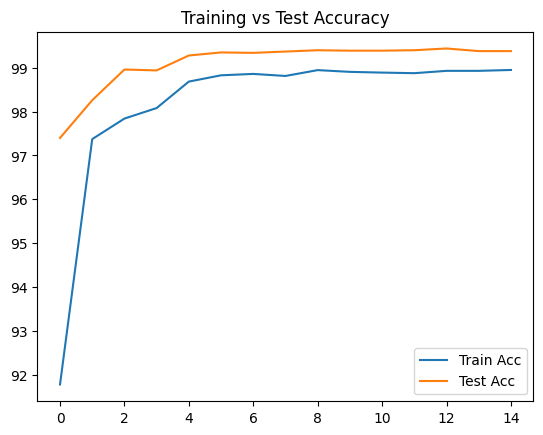

In [21]:
class model_getter:
    def __init__(self,device=None):
        self.device = device if device else self.get_device()
        self.model_obj = self.get_model()

    def get_device(self):
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def get_model(self):
        return Net().to(self.device)

    def get_dataloader_args(self):
        if self.device.type == "cuda":
            return dict(batch_size_train=32, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0, pin_memory=False)
        else:
            return dict(batch_size_train=32, batch_size_test=1000, shuffle_train=True, shuffle_test=False, num_workers=0)

def get_model_obj():
    model_i = model_getter()
    summary(model_i.model_obj, input_size=(1, 28, 28))
    return model_i

def do_run(model):
    dataloader_args = model.get_dataloader_args()
    data_setup_instance = DataSetup(**dataloader_args)
    train_test_instance = train_test_model(model.model_obj, model.device, data_setup_instance.train_loader, data_setup_instance.test_loader)
    train_test_instance.run_epoch(epochs=15)
    train_test_instance.plot_results()

def main():
    # Initialize model, data loaders, and training/testing framework
    model = get_model_obj() #model_getter()
    #summary(model.model_obj, input_size=(1, 28, 28))
    do_run(model)
    #model_checks(model.model_obj)

main()